In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [6]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [7]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge2(SOURCE, TARGET, FIG_SIZE):

    # 01 calculate the number of dimensions
    #dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # STFT -> spectrogram
    hop_length = 512  # in num. of samples
    n_fft = 2048  # window in num. of samples

    # perform stft
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft)  # np.abs(stft) ** 2

    # apply logarithm to cast amplitude to Decibels
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=FIG_SIZE)
      plt.axis('off')
      librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [8]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [9]:
# import PIL
# import PIL.Image
# import tensorflow as tf
# import tensorflow_datasets as tfds

# 이미지 로드 및 전처리
# 참고: https://www.tensorflow.org/tutorials/load_data/images?hl=ko
#       Tensorflow공식 튜토리얼: 이미지 로드 및 전처리하기 
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
# import tensorflow_datasets as tfds

In [10]:
print(tf.__version__)

2.8.0


In [11]:
# 데이터세트 형식으로 만들기
import pathlib

# data_dir = pathlib.Path('./content/data/out')
data_dir = pathlib.Path('./dataset/36cc_out')
print(type(data_dir))
print(data_dir)

<class 'pathlib.WindowsPath'>
dataset\36cc_out


In [12]:
# image count
# image_count = len(list(data_dir.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

40


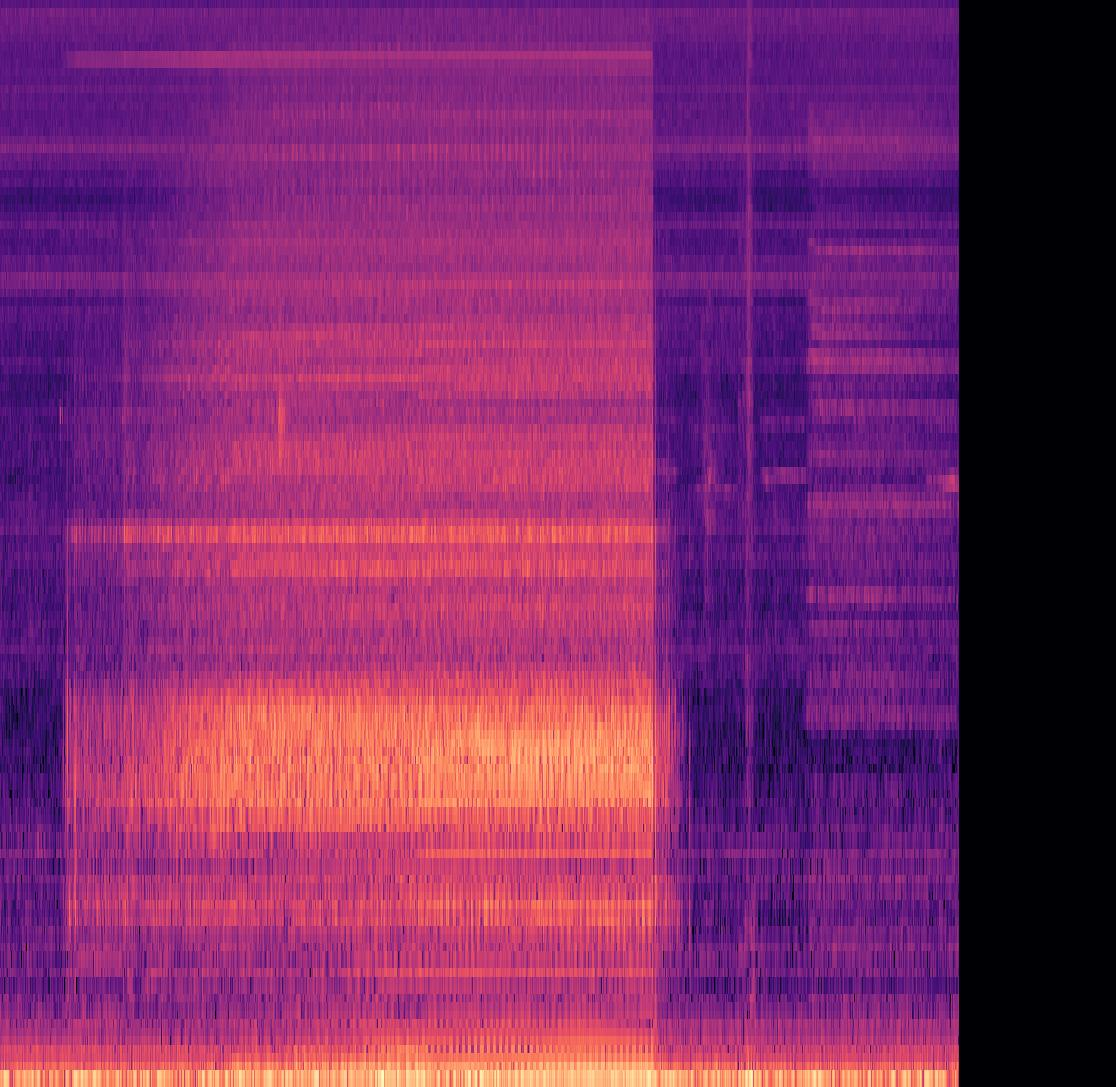

In [13]:
# image 1개 보기
# a_h = list(data_dir.glob('a_h/*'))
normal = list(data_dir.glob('normal/*'))
PIL.Image.open(str(normal[11]))

In [14]:
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tensorflow.keras as keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pathlib
import librosa
import librosa.display
import concurrent.futures

In [15]:
'''
2. Load training images  
'''
# resize and normalize data for training


def create_training_data(data_path, size=224):
    training_data = []
    # for category in CATEGORIES:  # "baseline" and "rattle"

    #     path = os.path.join(data_path, category)  # create path
    #     # get the classification  (0 or a 1). 0=baseline 1=rattle
    #     class_index = CATEGORIES.index(category)

    # iterate over each image
    for image in os.listdir(data_path):
        # check file extention
        if image.endswith(".jpg"):
            try:
                data_path = pathlib.Path(data_path)
                full_name = str(pathlib.Path.joinpath(data_path, image))
                data = cv2.imread(str(full_name), 0)
                # resize to make sure data consistency
                resized_data = cv2.resize(data, (size, size))
                # add this to our training_data
                training_data.append([resized_data])
            except Exception as err:
                print("an error has occured: ", err, str(full_name))

    # normalize data
    training_data = np.array(training_data)/255.
    # reshape
    training_data = np.array(training_data).reshape(-1, size, size)
    return training_data

In [16]:
'''
3. Build autoencoder 
'''
# Define a convolutional Autoencoder


class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        # input layer
        self.latent_dim = latent_dim
        # 1st dense layer
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(32, activation='relu'),

        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(224*224, activation='sigmoid'),
            layers.Reshape((224, 224))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [17]:
'''
4. Set threshold
'''


def model_threshold(autoencoder, x_train):
    encoded_imgs = autoencoder.encoder(x_train).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    loss = tf.keras.losses.mse(decoded_imgs, x_train)
    mean = np.mean(loss)
    std = np.std(loss)
    threshold = np.mean(loss) + np.std(loss)
    return loss, mean, std, threshold

In [18]:
'''
5. Make an inference
'''


def spectrogram_loss(autoencoder, spectrogram, size=224):
    data = np.ndarray(shape=(1, size, size), dtype=np.float32)
    # individual sample
    # Load an image from a file
    data = cv2.imread(str(spectrogram), 0)
    # resize to make sure data consistency
    resized_data = cv2.resize(data, (size, size))
    # nomalize img
    normalized_data = resized_data.astype('float32') / 255.
    # test an image
    encoded = autoencoder.encoder(normalized_data.reshape(-1, size, size))
    decoded = autoencoder.decoder(encoded)
    loss = tf.keras.losses.mse(decoded, normalized_data)
    sample_loss = np.mean(loss) + np.std(loss)
    return sample_loss

In [19]:
'''
2. Load training images
'''
data_path = "./dataset/36cc_out/normal"
x_train = create_training_data(data_path)

data_path = "./dataset/36cc_out/normal_test"
x_test_normal = create_training_data(data_path)

data_path = "./dataset/36cc_out/abnormal"
x_test_abnormal = create_training_data(data_path)

In [20]:
from sklearn.model_selection import train_test_split
X_train_split, X_test_split, __ , __ = train_test_split(x_train, x_train, test_size=0.05, random_state=42)


In [21]:
print(X_train_split.shape)
print(X_test_split.shape)

(34, 224, 224)
(2, 224, 224)


In [22]:
'''
3. Build autoencoder 
'''
autoencoder = Autoencoder(latent_dim=64*2)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(X_train_split, X_train_split,
						  epochs=100,
						  #shuffle=True,
						  batch_size=16, verbose=1,
						  validation_data=(X_test_split, X_test_split))

Epoch 1/100
3/3 [==============================] - 1s 49ms/step - loss: 0.0831 - val_loss: 0.0799
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0713 - val_loss: 0.0481
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0409 - val_loss: 0.0210
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0195 - val_loss: 0.0112
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0092
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 11/100
3/3 [=

In [23]:
# a summary of architecture
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 32)                1605664   
                                                                 
Total params: 1,605,664
Trainable params: 1,605,664
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 50176)             1655808   
                                                                 
 reshape (Reshape)           (None, 224, 224)          0         
                                                                 
Total params: 1,655,808


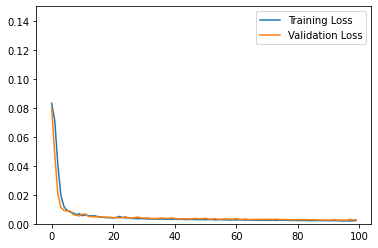

In [24]:
# plot history
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.ylim([0, 0.15])
plt.show()

In [25]:
print("loss: ", np.mean(history.history["loss"]))
print("val_loss: ", np.mean(history.history["val_loss"]))

loss:  0.00539600528543815
val_loss:  0.005211583534255624


In [26]:
# # save and load a mode
# autoencoder.save('./model_36cc/')
# autoencoder = keras.models.load_model('./model_36cc/')

In [27]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = Autoencoder(latent_dim=64 * 2)
# 	autoencoder = keras.models.load_model('./model_36cc/')

In [28]:
'''
4. Set threshold
'''
loss, mean, std, threshold = model_threshold(autoencoder, x_train)
# loss = tf.keras.losses.mse(decoded_imgs, x_train)
# threshold = np.mean(loss) + np.std(loss)
print("Loss Threshold: ", threshold)

Loss Threshold:  0.003850661328075332


In [29]:
# # load autoencoder model
# if autoencoder is None:
# 	autoencoder = keras.models.load_model('./model_36cc/')

In [30]:
# '''
# 5. Make an inference - abnormal 1
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/abnormal/36cc_NO_2208211119H0010019698_TDM_2022-03-30_16-22-03__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [31]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [32]:
# '''
# 5. Make an inference - abnormal 2
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/abnormal/36cc_NO_2208212119H0010019788_TDM_2022-03-30_15-55-34__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [33]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [34]:
# '''
# 5. Make an inference - normal 1
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/normal_test/test_36cc_OK_2208211119H0010019538_TDM_2022-03-30_15-46-18__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [35]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [36]:
# '''
# 5. Make an inference - abnormal 2
# '''
# # get statistics for each spectrogram
# # file = 'c:/data/sample/test_OK_anomal_121282111NB982000301518.jpg'
# # file = 'c:/data/sample/test_OK_121282111NB982000295218.jpg'
# file = './dataset/36cc_out/normal_test/test_36cc_OK_2208211119H0010019618_TDM_2022-03-30_16-15-17__Microphone.jpg'
# sample = plt.imread(file)
# plt.imshow(sample)
# sample = pathlib.Path(file)
# sample_loss = spectrogram_loss(autoencoder, sample)

In [37]:
# if sample_loss > threshold:
# 	print(
# 		f'Loss is bigger than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')
# else:
# 	print(
# 		f'Loss is smaller than threshold \n \
# 		  Sample Loss: {sample_loss} \n \
# 		  Threshold: {threshold} ')

In [38]:
x_train_loss, x_train_mean, x_train_std, x_train_threshold = model_threshold(autoencoder, x_train)
x_tran_loss_all = []
for i in range(x_train_loss.shape[0]):
    x_tran_loss_all.append(np.mean(x_train_loss[i]))
    print(i, ": ", np.mean(x_train_loss[i]))

0 :  0.0012743562862320707
1 :  0.0017050035329972512
2 :  0.0015148281652989006
3 :  0.0014670010783278317
4 :  0.0028386863776579457
5 :  0.002583357539120131
6 :  0.0019946807892595435
7 :  0.006310301221659126
8 :  0.0013870079323033936
9 :  0.0017628999918535772
10 :  0.0016742758885786614
11 :  0.001828006049731575
12 :  0.0015265312339465265
13 :  0.0019211033585479459
14 :  0.0014990816856957064
15 :  0.0017986356835549833
16 :  0.001588643081158968
17 :  0.001497353900446529
18 :  0.001824297240544448
19 :  0.002188250886377359
20 :  0.0021813487354591177
21 :  0.0016943011782645373
22 :  0.001799945031848313
23 :  0.0014422102799385409
24 :  0.0018949310260008637
25 :  0.0018703342327505688
26 :  0.0023309309023833466
27 :  0.0016077120717468407
28 :  0.0012838638607079887
29 :  0.001347256232002335
30 :  0.0016297763794519543
31 :  0.0025488146124128244
32 :  0.0016022384184441964
33 :  0.0016013126283618245
34 :  0.001526441307586734
35 :  0.003500435925286326


threshold:  0.003850661328075332


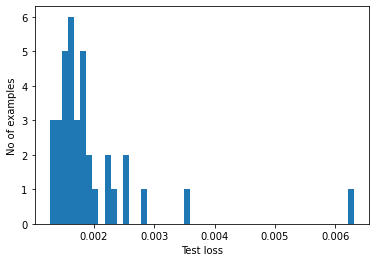

In [39]:
print("      loss: ", threshold)
print("mean(loss): ", mean)
print(" std(loss): ", std)
print(" threshold: ", threshold)
print("strong threshold: ", mean+std/2)
plt.hist(x_tran_loss_all, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [40]:
ok_loss, nok_mean, nok_std, nok_threshold = model_threshold(autoencoder, x_test_normal)
ok_loss_all = []
for i in range(ok_loss.shape[0]):
    ok_loss_all.append(np.mean(ok_loss[i]))
    print(i, ": ", np.mean(ok_loss[i]))

0 :  0.0017278518725309458
1 :  0.0016698002066592172


In [ ]:
print("threshold: ", threshold)
plt.hist(ok_loss_all, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [41]:
nok_loss, nok_mean, nok_std, nok_threshold = model_threshold(autoencoder, x_test_abnormal)
nok_loss_all = []
for i in range(nok_loss.shape[0]):
    nok_loss_all.append(np.mean(nok_loss[i]))
    print(i, ": ", np.mean(nok_loss[i]))

0 :  0.005266640439511912
1 :  0.008994809035026561


threshold:  0.003850661328075332


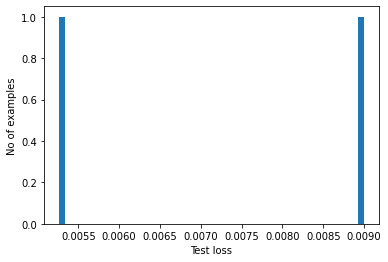

In [42]:
print("threshold: ", threshold)
plt.hist(nok_loss_all, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()